# ЗАДАЧА

К вам обратился представитель крупного агентства недвижимости со следующей проблемой:

Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивает до уровня конкурентов. А это сказывается на наших финансовых показателях. Твоя задача — разработать модель, которая бы позволила обойти конкурентов по скорости и качеству совершения сделок. Датасет прикладываю.

## НУЖНО
разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.  

In [1]:
#импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
from statistics import mean
import pickle

In [2]:
#настройки
%matplotlib inline
pd.options.display.max_columns = 30

In [3]:
#загружаем данные и делаем копию датасета, чтобы работать с копией
data_source = pd.read_csv('data.csv')

In [4]:
#подгружаем данные по городам
data_cities = pd.read_csv('USA_Major_Cities.csv')

# 0. Посмотрим на данные о городах

In [5]:
data_cities.head()

,FID,NAME,CLASS,ST,STFIPS,PLACEFIPS,CAPITAL,POP_CLASS,POPULATION,POP2010,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,...,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC
0,1,Ammon,city,ID,16,1601990,,6,15181,13816,13002,73,67,113,9,...,30.8,4476,3.05,457,648,1618,1131,106,335,3352,3.61,4747,271,3205,1271
1,2,Blackfoot,city,ID,16,1607840,,6,11946,11899,9893,40,418,125,18,...,32.1,4229,2.74,563,690,1091,1081,174,381,2958,3.31,4547,318,2788,1441
2,3,Boise City,city,ID,16,1608830,State,8,225405,205671,182991,3043,1404,6501,457,...,36.5,85704,2.36,16605,18104,16708,21233,2414,5919,50647,2.97,92700,6996,52345,33359
3,4,Burley,city,ID,16,1611260,,6,10727,10345,7984,45,103,74,5,...,32.3,3644,2.76,498,634,950,861,139,358,2499,3.37,3885,241,2183,1461
4,5,Caldwell,city,ID,16,1612250,,7,53942,46237,35856,300,539,406,41,...,28.9,14895,3.00,1795,2250,4407,3113,686,1755,10776,3.51,16323,1428,9699,5196


In [6]:
data_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         3886 non-null   int64  
 1   NAME        3886 non-null   object 
 2   CLASS       3886 non-null   object 
 3   ST          3886 non-null   object 
 4   STFIPS      3886 non-null   int64  
 5   PLACEFIPS   3886 non-null   int64  
 6   CAPITAL     3886 non-null   object 
 7   POP_CLASS   3886 non-null   int64  
 8   POPULATION  3886 non-null   int64  
 9   POP2010     3886 non-null   int64  
 10  WHITE       3886 non-null   int64  
 11  BLACK       3886 non-null   int64  
 12  AMERI_ES    3886 non-null   int64  
 13  ASIAN       3886 non-null   int64  
 14  HAWN_PI     3886 non-null   int64  
 15  HISPANIC    3886 non-null   int64  
 16  OTHER       3886 non-null   int64  
 17  MULT_RACE   3886 non-null   int64  
 18  MALES       3886 non-null   int64  
 19  FEMALES     3886 non-null  

In [7]:
data_cities['CAPITAL'].unique()

array([' ', 'State', 'National'], dtype=object)

In [8]:
data_cities['NAME'] = data_cities['NAME'].apply(lambda x: x.lower())
data_cities['CAPITAL'].fillna(0, inplace=True)
data_cities['CAPITAL'] = data_cities['CAPITAL'].apply(lambda x: 0 if x==' ' else 1)
data_source['city'] = data_source['city'].apply(lambda x: str(x).lower())

In [9]:
data_new = data_source.merge(data_cities[['NAME', 'ST', 'CAPITAL', 'POPULATION', 'MALES', 'FEMALES', 'HSE_UNITS', 'VACANT', 'OWNER_OCC']], 
                      how = 'left', left_on = ['city', 'state'], right_on= ['NAME', 'ST'])

In [10]:
data_new.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,NAME,ST,CAPITAL,POPULATION,MALES,FEMALES,HSE_UNITS,VACANT,OWNER_OCC
0,Active,NaN,Two Story,7684 Foxcroft Ln,"2,000","{'atAGlanceFacts': [{'factValue': '2009', 'fac...",NaN,davie,"[{'rating': ['8', '6', '4'], 'data': {'Distanc...","1,696",33328,Baths,FL,NaN,NaN,NaN,A10756114,339900,davie,FL,0.0,100860.0,44562.0,47430.0,37306.0,2991.0,25287.0
1,for sale,NaN,single-family home,858 SW McCoy Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,port saint lucie,"[{'rating': ['8/10', '5/10', '4/10', '3/10', '...","1,192 sqft",34953,3 Beds,FL,1.0,NaN,yes,RX-10574455,223000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,for sale,NaN,lot/land,6083 La Jolla Scenic Dr S #S,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,la jolla,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",NaN,92037,NaN,CA,NaN,NaN,NaN,190052869,3195000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Active,NaN,"Two Story, Spanish/Mediterranean",2643 SW 139 Ave,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,miami,"[{'rating': ['9', '10', 'NR', '6', '5'], 'data...",NaN,33175,NaN,FL,NaN,NaN,NaN,A10772260,715000,miami,FL,0.0,449517.0,198927.0,200530.0,183994.0,25677.0,51186.0
4,for sale,NaN,single-family home,612 Hawthorne St,4 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",yes,houston,"[{'rating': ['6/10', '5/10', '3/10'], 'data': ...","4,535 sqft",77006,3 Beds,TX,3.0,NaN,yes,49464471,1224500,houston,TX,0.0,2333285.0,1053517.0,1045934.0,892646.0,110003.0,355236.0


In [11]:
data = data_new.copy()

Посмотрим на состав данных

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374687 entries, 0 to 374686
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335392 non-null  object 
 1   private pool  4197 non-null    object 
 2   propertyType  340127 non-null  object 
 3   street        374686 non-null  object 
 4   baths         269465 non-null  object 
 5   homeFacts     374687 non-null  object 
 6   fireplace     102486 non-null  object 
 7   city          374687 non-null  object 
 8   schools       374687 non-null  object 
 9   sqft          334483 non-null  object 
 10  zipcode       374687 non-null  object 
 11  beds          283832 non-null  object 
 12  state         374686 non-null  object 
 13  stories       224861 non-null  object 
 14  mls-id        25078 non-null   object 
 15  PrivatePool   40296 non-null   object 
 16  MlsId         310313 non-null  object 
 17  target        374687 non-null  int64  
 18  NAME

In [13]:
data.describe()

,target,CAPITAL,POPULATION,MALES,FEMALES,HSE_UNITS,VACANT,OWNER_OCC
count,3.746870e+05,325128.000000,3.251280e+05,3.251280e+05,3.251280e+05,3.251280e+05,325128.000000,325128.000000
mean,6.427223e+05,0.097774,8.600082e+05,3.878290e+05,4.052917e+05,3.376981e+05,35455.450816,135304.239103
std,1.762787e+06,0.297009,1.404359e+06,6.337612e+05,6.846455e+05,5.423866e+05,48146.883623,174727.353736
min,1.000000e+00,0.000000,1.019400e+04,4.733000e+03,3.292000e+03,2.775000e+03,70.000000,698.000000
25%,1.864500e+05,0.000000,1.047040e+05,4.596900e+04,4.619900e+04,3.899500e+04,4693.000000,22041.000000
50%,3.200000e+05,0.000000,4.240720e+05,1.902850e+05,2.005300e+05,1.761240e+05,20908.000000,51186.000000
75%,5.849500e+05,0.000000,8.869690e+05,3.982940e+05,4.234900e+05,3.662730e+05,43167.000000,199378.000000
max,1.650000e+08,1.000000,8.691599e+06,3.882544e+06,4.292589e+06,3.371062e+06,261278.000000,962892.000000


## 1. target

Поле содержит информацию о стоимости дома. Это наша целевая переменная. Строки, в которых отсутствует значение, откидываем, так как ни для обучения, ни для тестирования они не пригодятся.
Кроме того, откинем строки, в которых значение целевой переменной = 1. Это маловероятная ситуация

In [14]:
#количество строк, в которых не задана стоимость дома
sum(data['target'].isnull())

0

In [24]:
sum(data['state'].isnull())

0

In [23]:
data=data[data['state'].notnull()]

In [15]:
#Посмотрим на статусы этих домов (foreclosure = потеря права выкупа, pending = незавершенное строительство)
data['status'][data['target'].isnull()].unique()

array([], dtype=object)

In [16]:
#отложим строки, в которых не задана целевая переменная, в сторону. 
#В дальнейшем эти данные можно будет использовать для примера работы прототипа
data_for_example = data[data['target'].isnull()]
data = data[data['target'].notnull()]

print('Осталось {0} записей из {1}'.format(len(data), len(data_source)))

Осталось 374687 записей из 374687


In [17]:
#Смотрим, какие значения есть в target. Нам нужно, чтобы они были все числовые
data['target'].unique()

array([ 339900,  223000, 3195000, ...,  113982,  255915,  899998],
      dtype=int64)

In [18]:
#убираем все символы, кроме цифр. Приводим к формату int
regex = re.compile('\D+')
data['target'] = data['target'].apply(lambda x: int(regex.sub('', str(x))))

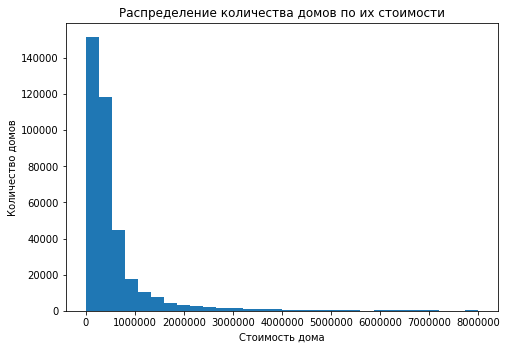

In [19]:
fig_target = plt.figure()
axes_target = fig_target.add_axes([0, 0, 1, 1])
axes_target.hist(data['target'], range = (data['target'].min(), 8000000), bins = 30)
axes_target.set_xlabel('Стоимость дома')
axes_target.set_ylabel('Количество домов')
axes_target.set_title('Распределение количества домов по их стоимости')
plt.show()
#видим, что целевая переменная сосредоточена до 1 млн, и распределение мало напоминает нормальное 
# + есть выбросы значений больше 8 млн (поставлено такое ограничение, так как если брать во внимание все значения из датасета,
# то получается малоинформативный график)

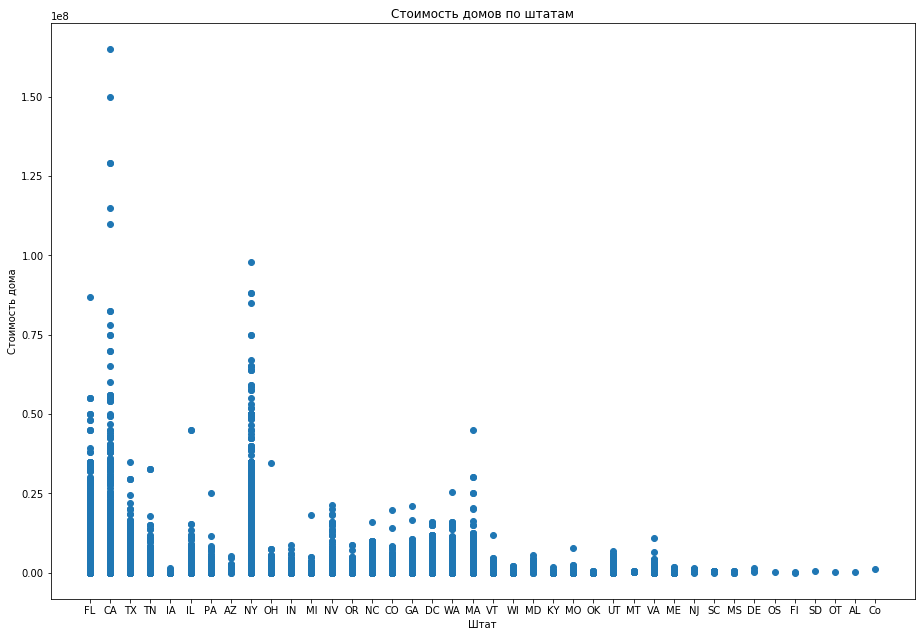

In [26]:
X = data[['state', 'target']]

fig_target_st = plt.figure()
axes_target_st = fig_target_st.add_axes([0, 0, 2, 2])
axes_target_st.set_xlabel('Штат')
axes_target_st.set_ylabel('Стоимость дома')
axes_target_st.set_title('Стоимость домов по штатам')
plt.plot(X['state'], X['target'],'o')
plt.show()

In [27]:
data['target'].describe()

count    3.746860e+05
mean     6.427233e+05
std      1.762789e+06
min      1.000000e+00
25%      1.864500e+05
50%      3.200000e+05
75%      5.849500e+05
max      1.650000e+08
Name: target, dtype: float64

In [28]:
#убираем значения стоимости дома = 1 или меньше
data = data.loc[data['target']>1]

Отметим, что стоимость домов сильно отличается по штатам. Добавим еще одну колонку со средней стоимостью дома по штату.

In [29]:
mean_target = data.groupby(by = ['state'])['target'].mean()

In [30]:
data['state_mean'] = data['state'].apply(lambda x: mean_target[x])

## 2. поле status

Поле содержит информацию о статусе продажи дома. 
Значение необходимо учитывать, так как есть дома для аренды, в этом случае его цена указана «за месяц».


In [31]:
data['status'].unique()

array(['Active', 'for sale', 'For sale', nan, 'Pending',
       'New construction', 'foreclosure', 'Under Contract Show',
       'Pre-foreclosure / auction', 'Under Contract', 'Pre-foreclosure',
       'A Active', 'Contingent Finance And Inspection',
       'Active Under Contract', 'Foreclosure', 'Price Change', 'P',
       'Under Contract   Showing', ' / auction', 'Contingent', 'New',
       'Ct', 'Active Backup', 'Auction', 'Pi', 'Option Pending',
       'Contract Contingent On Buyer Sale', 'Pending Bring Backup',
       'Coming soon: Oct 17.', 'for rent', 'Under Contract Backups',
       'Foreclosed', 'Pending Continue To Show',
       'Active With Contingencies', 'Back on Market',
       'Pending With Contingencies', 'C', 'Pending - Taking Backups',
       'Pending W/Backup Wanted', 'Active With Offer', 'Contract',
       'CT Insp - Inspection Contingency', 'Contract P',
       'Contingent Take Backup', 'Pending Taking Backups',
       'Contingent Show', 'Coming soon: Dec 4.', 'Com

In [32]:
#разделяем данные на 2 категории. Для продажи и для аренды. Так как от этого фактора сильно зависит итоговая стоимость
data['rent_sale']=data['status'].apply(lambda x: 1 if str(x).lower().find('rent') >-1 else 0)

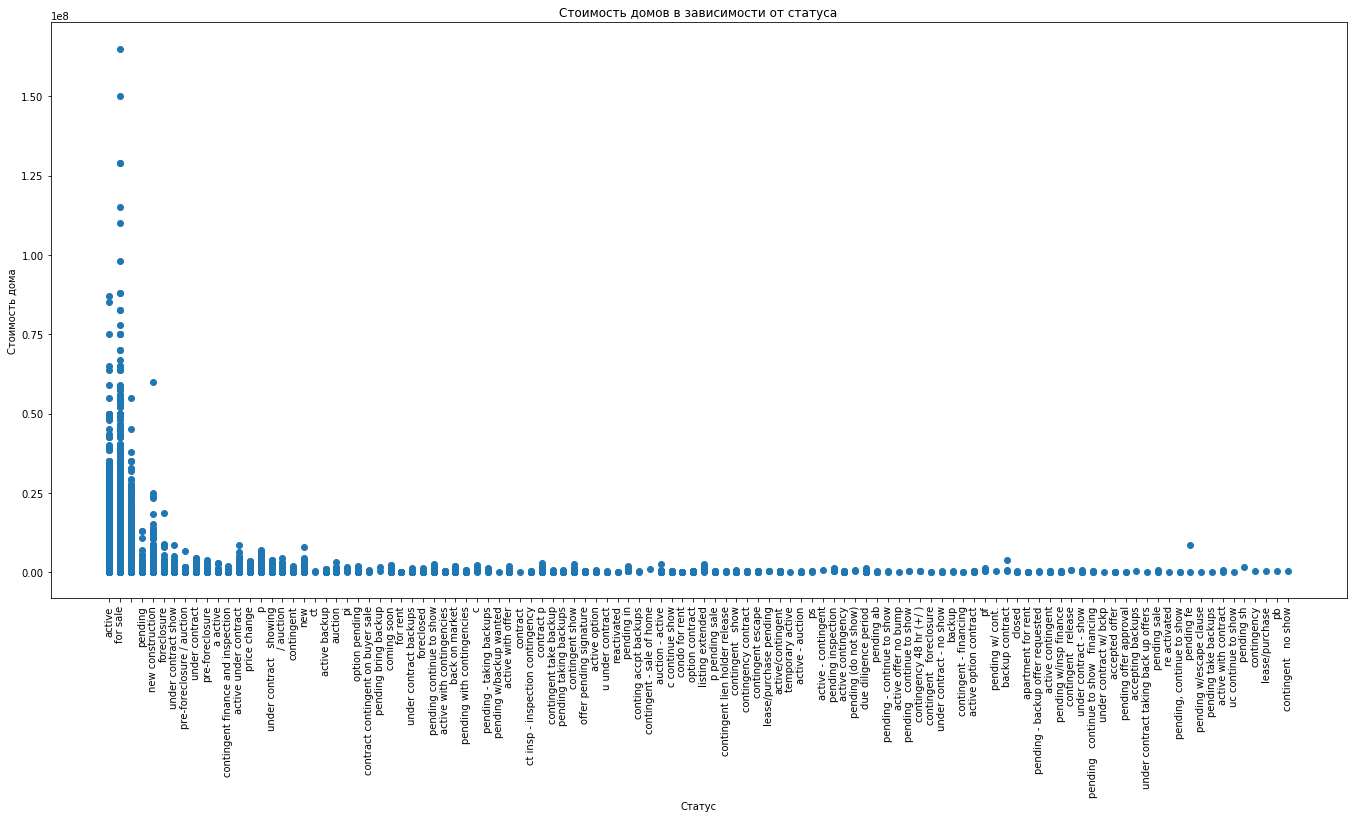

In [33]:
data['status'].fillna('', inplace = True)
data['status'] = data['status'].apply(lambda x: 'coming soon' if str(x).lower().find('coming soon') >-1 else x.lower())
X_status = data[['status', 'target']]

fig_target_status = plt.figure()
axes_target_status = fig_target_status.add_axes([0, 0, 3, 2])
axes_target_status.set_xlabel('Статус')
axes_target_status.set_ylabel('Стоимость дома')
axes_target_status.set_title('Стоимость домов в зависимости от статуса')
plt.xticks(rotation=90)
#axes_target_status.set_xticklabels(X_status['status'], rotation =90 )
plt.plot(X_status['status'], X_status['target'],'o')
plt.show()

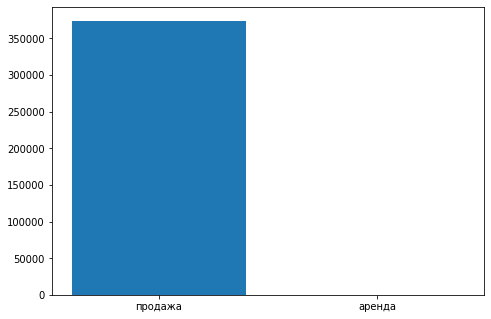

In [34]:
#посмотрим после обработки
rent_sale = data.groupby('rent_sale')['rent_sale'].count().sort_values(ascending=False)

fig_rent = plt.figure()
axes_rent = fig_rent.add_axes([0,0,1,1])
axes_rent.bar(x = ['нет', 'да'], height = rent_sale.values)
axes_rent.set_xticklabels(['продажа', 'аренда'], rotation = 0 )    #  Поворот текста
plt.show()

## 3. поле propertyType

Поле содержит информацию о типе дома. Приводим некоторые типы к единому стилю (пример: 'single-family home','Single Family Home','Single Family'). Считаем hash, так как непонятно, сколько может быть таких типов

In [35]:
def replace_property(row):
    
    if row in ['single-family home','Single Family Home','Single Family']:
        return 'single family home'
    elif row == 'Condo':
        return 'condo'
    elif row in ['Townhouse', 'Townhome']:
        return 'townhouse'
    elif row in ['Multi-Family Home','multi-family','Multi Family','Multi-Family']:
        return 'multi family home'
    elif row in ['1 Story','One Story']:
        return '1 story'
    elif row in ['2 Stories', '2 Story', 'Two Story']:
        return '2 stories'
    elif row in ['mobile/manufactured', 'Mfd/Mobile Home', 'Mobile / Manufactured']:
        return 'mobile/manufactured'
    elif row in ['Cooperative', 'coop']:
        return 'cooperative'
    elif row in ['Apartment', 'apartment']:
        return 'apartment'
    elif row in ['lot/land', 'Land']:
        return 'land'
    elif row in ['Other Style', 'Other']:
        return 'other style'
    else:
        return row

In [36]:
#приводим к более-менее одинаковым названиям
data['prop_type']=data['propertyType'].apply(lambda x: replace_property(x))

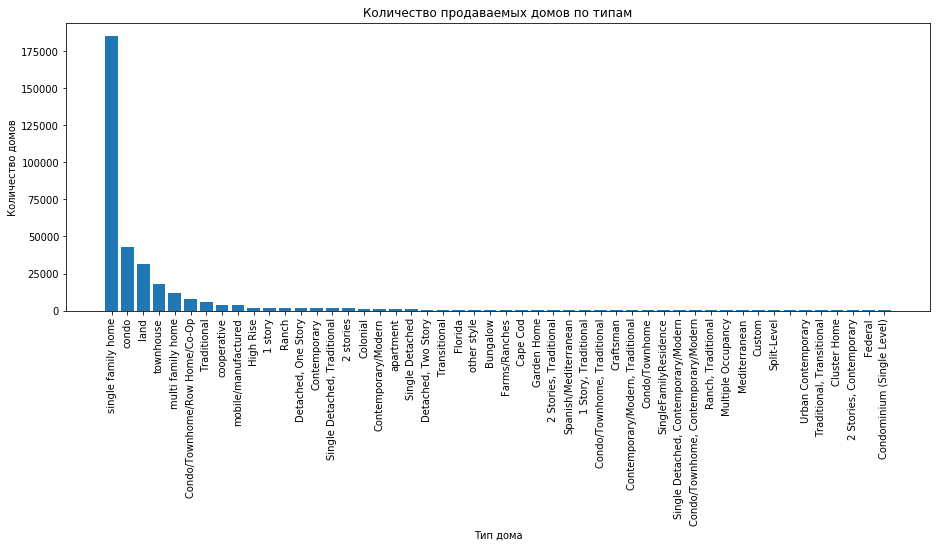

In [37]:
#считаем распределение по типам собственности
#prop_type = data.groupby('propertyType')['propertyType'].count().sort_values(ascending=False)
prop_type = data.groupby('prop_type')['prop_type'].count().sort_values(ascending=False)

NUM_PROP =50 #выводим первые 30 по численности
fig_prop = plt.figure()
axes_prop = fig_prop.add_axes([0,0,2,1])
axes_prop.bar(x = prop_type.index[:NUM_PROP], height = prop_type.values[:NUM_PROP])
axes_prop.set_ylabel('Количество домов')
axes_prop.set_xlabel('Тип дома')
axes_prop.set_title('Количество продаваемых домов по типам')

axes_prop.set_xticklabels(prop_type.index, rotation =90 )    #  Поворот текста
plt.show()

In [38]:
#считаем hash
hash_space=50
data['prop_type']=data['prop_type'].apply(lambda x: hash(''.join(str(x).lower().split())) % hash_space)
#удаляем исходное поле
data = data.drop(['propertyType'], axis = 'columns')

## 4. поля city, street

Поле city содержит название города. Заменяем пропущенные значения на ‘no_city’. Приводим все названия к нижнему регистру. Количество уникальных значений сократилось с 2026 до 1909. Это преобразование используем только для визуализации графиков.

Поле street содержит часть адреса дома (улица, номер дома).

Так как улиц и городов может быть много, и неизвестно, может быть в новых данных встретятся неизвестные нам сейчас значения, то считаем hash. Формируем новые столбцы:
* отдельно по улицам, 
* отдельно по городам, 
* вместе от целой строки «город+улица».


In [39]:
data[['city', 'street']]

,city,street
0,davie,7684 Foxcroft Ln
1,port saint lucie,858 SW McCoy Ave
2,la jolla,6083 La Jolla Scenic Dr S #S
3,miami,2643 SW 139 Ave
4,houston,612 Hawthorne St
...,...,...
374682,miami,19800 SW 180th Ave LOT 173
374683,chicago,1053 N Ridgeway Ave
374684,colonie,79 Morris Rd #B
374685,houston,5766 Sugar Hill Dr


In [40]:
# заполняем пропущенные значения на "no_city"
data['city'].fillna('no_city', inplace=True)

# приводим все буквы к нижнему регистру, так как есть вероятность, что города могут быть написаны по-разному
data['city_lower'] = data['city'].apply(lambda x: str(x).lower() if x != ' ' else 'no_city')
print(data['city'].nunique(), '->', data['city_lower'].nunique())

1922 -> 1922


In [41]:
hash_space_city = 20000
hash_space_street = 500000
data['city_hash']=data['city'].apply(lambda x: hash(''.join(x.lower().split())) % hash_space_city)
data['street_hash']=data['street'].apply(lambda x: hash(''.join(str(x).lower().split())) % hash_space_street)
data['address_hash']=data[['city', 'street']].apply(lambda x: hash(''.join(str(x[0]).lower().split()) + 
                                                                  ''.join(str(x[1]).lower().split())) % hash_space_street, axis=1)

In [42]:
data[['city_hash', 'city', 'street', 'street_hash', 'address_hash']]

,city_hash,city,street,street_hash,address_hash
0,1658,davie,7684 Foxcroft Ln,399765,412709
1,7402,port saint lucie,858 SW McCoy Ave,307440,54271
2,4785,la jolla,6083 La Jolla Scenic Dr S #S,246418,101867
3,6814,miami,2643 SW 139 Ave,323522,106163
4,3409,houston,612 Hawthorne St,399363,392815
...,...,...,...,...,...
374682,6814,miami,19800 SW 180th Ave LOT 173,473772,337364
374683,13653,chicago,1053 N Ridgeway Ave,290356,314960
374684,11905,colonie,79 Morris Rd #B,116451,496691
374685,3409,houston,5766 Sugar Hill Dr,110052,105621


### поле city отдельно

In [43]:
data_source['city'].nunique()

1923

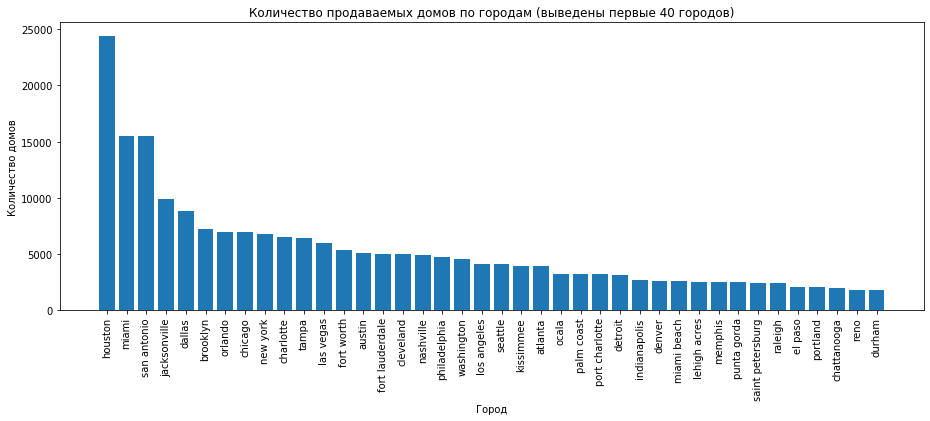

In [44]:
#считаем распределение по городам
cities = data.groupby('city_lower')['city_lower'].count().sort_values(ascending=False)

#групбай удаляет значения, где город не указан. Добавим это количество в 
NUM_SITIES = 40

fig_cities = plt.figure()
axes_cities = fig_cities.add_axes([0,0,2,1])
axes_cities.bar(x = cities.head(NUM_SITIES).index, height = cities.head(NUM_SITIES).values)
axes_cities.set_xlabel('Город')
axes_cities.set_ylabel('Количество домов')
axes_cities.set_title('Количество продаваемых домов по городам (выведены первые '+str(NUM_SITIES)+' городов)')

axes_cities.set_xticklabels(cities.head(NUM_SITIES).index, rotation =90 )    #  Поворот текста
plt.show()

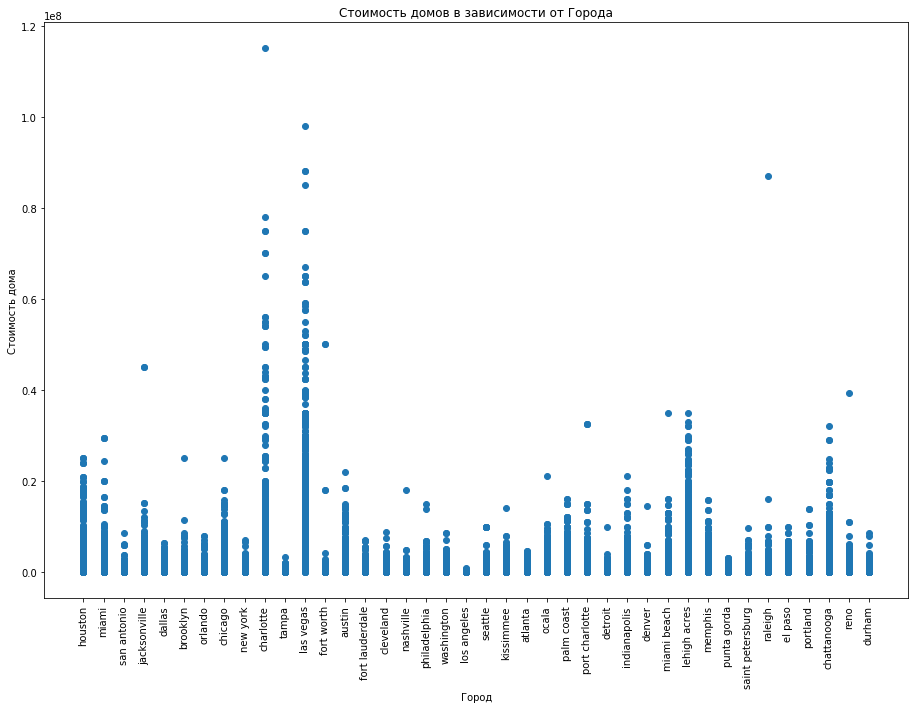

In [45]:
X_city = data[data['city_lower'].isin(cities.head(NUM_SITIES).index)][['city_lower', 'target']]

fig_target_city = plt.figure()
axes_target_city = fig_target_city.add_axes([0, 0, 2, 2])
axes_target_city.set_xlabel('Город' )
axes_target_city.set_ylabel('Стоимость дома')
axes_target_city.set_title('Стоимость домов в зависимости от Города')
axes_target_city.set_xticklabels(cities.head(NUM_SITIES).index, rotation =90 )
plt.plot(X_city['city_lower'], X_city['target'],'o')
plt.show()

In [46]:
#удаляем исходные и ненужные столбцы
data = data.drop(['city', 'street','city_lower'], axis = 'columns')

## 5. поле baths

Поле содержит информацию о количестве ванных комнат. Иногда указывается значение без опознавательных знаков, но число с разделителем «запятая». Считаем, что это опечатка и заменяем его на «точку». Преобразуем поле в «Количество ванных комнат», отбросив все слова. Тип нового поля float.

Если не указано количество ванных, то поставим = 1, так как без хотя бы одной ванной комнаты квартира маловероятна

In [47]:
#смотрим на значения, которые есть в поле beds в зависимости от типа идентификатора
data[data['mls-id'].notnull()]['baths'].unique()[:50]

array(['Bathrooms: 3', nan, 'Bathrooms: 6', '3 ba', 'Bathrooms: 2',
       '2 ba', 'Bathrooms: 1', '4 ba', 'Bathrooms: 5', 'Bathrooms: 7',
       'Bathrooms: 4', 'Bathrooms: 9', '-- baths', '1 ba', 'Bathrooms: 8',
       '10 ba', 'Bathrooms: 10', 'Bathrooms: 11', '5 ba', '6 ba', '8 ba',
       '7 ba', '9 ba', '3.5 ba', 'Bathrooms: 14', '2.25 ba', '12 ba',
       'Bathrooms: 12', '15 ba', '2 baths', 'Bathrooms: 13',
       'Bathrooms: 15', 'Bathrooms: 18', 'Bathrooms: 24', '11 ba',
       '5.5 ba', 'Bathrooms: 16', '1.1 ba', '2.5 ba'], dtype=object)

In [48]:
data[data['MlsId'].notnull()]['baths'].unique()[:50]

array(['2,000', '2 Baths', nan, '4 Baths', '3,000', '1.5', '2.0', '2.5',
       '3.0', '3 Baths', '2', '0', '4.0', '5 Baths', '5.0', '1,000',
       '8 Baths', '6 Baths', '3', '1,750', '5,000', '2,250', '1.0', '3.5',
       '7', '1', '~', '1,500', '9', '750', '5', '4', '4.5', '3,500',
       '5.5', '6', '11.0', '4,000', '6.0', '7 Baths', '1,250', '2,500',
       '9.0', '2.5 Baths', '2,750', '10.0', '7.0', '1.5 Baths',
       '24 Baths', '10 Baths'], dtype=object)

In [49]:
def make_baths_count(row):
    row = str(row)
    row = row.replace('Bathrooms: ', '').replace(' Baths', '').replace(' ba', '').replace(',','.')
    try:
        if row != 'nan':
            return float(row)
        else:
            return 1
    except:
        return 1

In [50]:
data['baths_count']=data['baths'].apply(lambda x: make_baths_count(x))

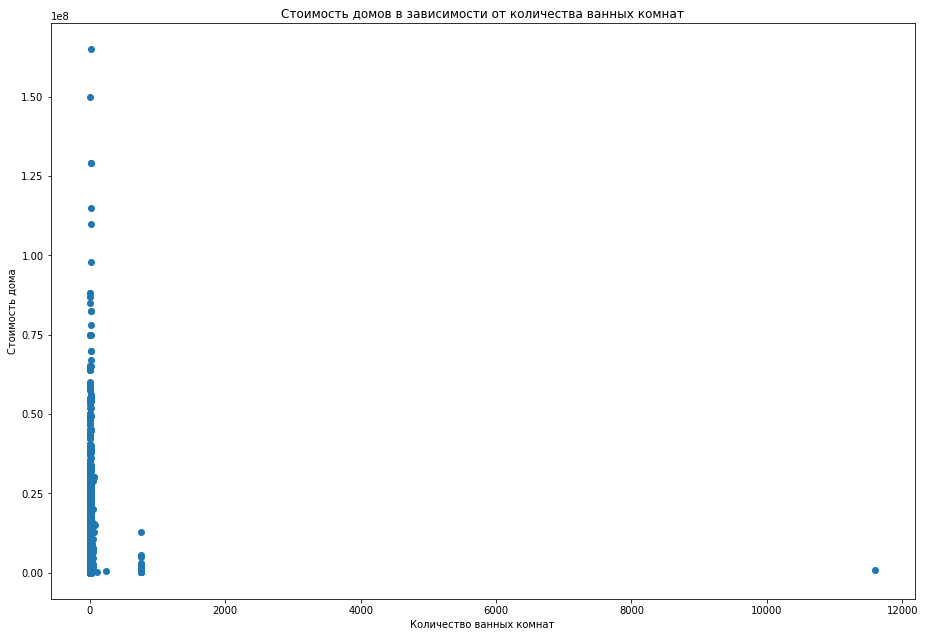

In [51]:
X_bath = data[['baths_count', 'target']]

fig_target_bath = plt.figure()
axes_target_bath = fig_target_bath.add_axes([0, 0, 2, 2])
axes_target_bath.set_xlabel('Количество ванных комнат')
axes_target_bath.set_ylabel('Стоимость дома')
axes_target_bath.set_title('Стоимость домов в зависимости от количества ванных комнат')
plt.plot(X_bath['baths_count'], X_bath['target'],'o')
plt.show()

In [52]:
# удаляем выбросы. Количество ванных комнат больше 200
data = data.loc[data['baths_count']<200]

In [53]:
data = data.drop(['baths'], axis = 'columns')

## 6. поле beds

Поле содержит информацию о количестве спальных комнат (иногда о их площади). 

Так как нет возможности оставить разнородную информацию в одном поле, то решено разделить данные на два поля: Количество спален и Площадь спален. При этом площадь переведена в квадратные метры, чтобы была единая единица измерения.


In [54]:
#смотрим на значения, которые есть в поле beds в зависимости от типа идентификатора
data[data['mls-id'].notnull()]['beds'].unique()[:50]

array(['3 bd', '2 bd', '5 bd', '4 bd', '1 bd', '7 bd', '6 bd', '-- bd',
       '0.32 acres', '1,188 sqft', '9 bd', '11 bd', '10 bd', '22 bd',
       '8 bd', '13 bd', '1,306 sqft', '4,356 sqft', '0.31 acres',
       '12.4 acres', '1,650 sqft', '449 acres', '12 bd', '0.47 acres',
       '1.8 acres', '5,078 sqft', '5,227 sqft', '2,000 sqft',
       '7,405 sqft', '1 acre', '24 bd', '0.4 acres', '3,920 sqft',
       '0.85 acres', '0.57 acres', '4,791 sqft', '0.26 acres', '14 bd',
       '2,850 sqft', '4.64 acres', '2,178 sqft', '10,018 sqft',
       '0.86 acres', '23 bd', '9,583 sqft', '15 bd', '17 bd', '8.2 acres',
       '46 bd', '16 bd'], dtype=object)

In [55]:
data[data['MlsId'].notnull()]['beds'].unique()[:50]

array(['Baths', '3 Beds', nan, '3', '4', '2 Beds', '5', '2.0', '4 Beds',
       '2', '5 Beds', '7 Beds', '6 Beds', '3.0', '6', '1.97 acres', '4.0',
       '1', '0.5 acres', '8 Beds', '6,599 sqft', '0.25 acres',
       '9.34 acres', '6.0', '5.0', '9 Beds', '7', '27.35 acres',
       '4,399 sqft', '4.71 acres', '7,200 sqft', '16 Beds', '5,000 sqft',
       '36 Beds', '0', '1.72 acres', '2.68 acres', '12', '11 Beds',
       '2 acres', 'Bath', '1.0', '27', '0.46 acres', '0.37 acres', '9',
       '6,821 sqft', '1.09 acres', '8', '10,798 sqft'], dtype=object)

In [56]:
def make_beds_count(row):
    row = str(row)
    if row.find(' Beds') > -1:
        try:
            return int(row.replace(' Beds', ''))
        except: #если указано что-то другое #1-2
            return 1
    elif row.find(' bd') >-1:
        try:
            return int(row.replace(' bd', ''))
        except: #если указано что-то другое #--
            return 0
    else: 
        try:
            return int(row)
        except:
            return 0

def make_beds_square(row): #переводим в квадратные метры
    row = str(row)
    if row.find(' sqft') > -1:
        try:
            return float(row.replace(' sqft', '').replace(',',''))*0.093
        except: 
            return 0
    elif row.find(' acres') > -1:
        try:
            return float(row.replace(' acres', '').replace(',',''))*4046.86
        except: 
            return 0
    else:
        return 0
        

In [57]:
data['beds_count']=data['beds'].apply(lambda x: make_beds_count(x))
data['beds_square']=data['beds'].apply(lambda x: make_beds_square(x))
#удаляем лишний столбец
data = data.drop(['beds'], axis = 'columns')

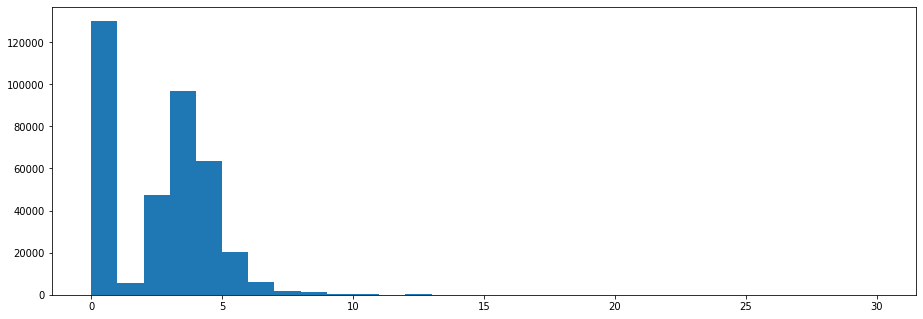

In [58]:
fig_beds = plt.figure()
axes_beds = fig_beds.add_axes([0, 0, 2, 1])
axes_beds.hist(data['beds_count'], range = (0, 30), bins=30)
plt.show()

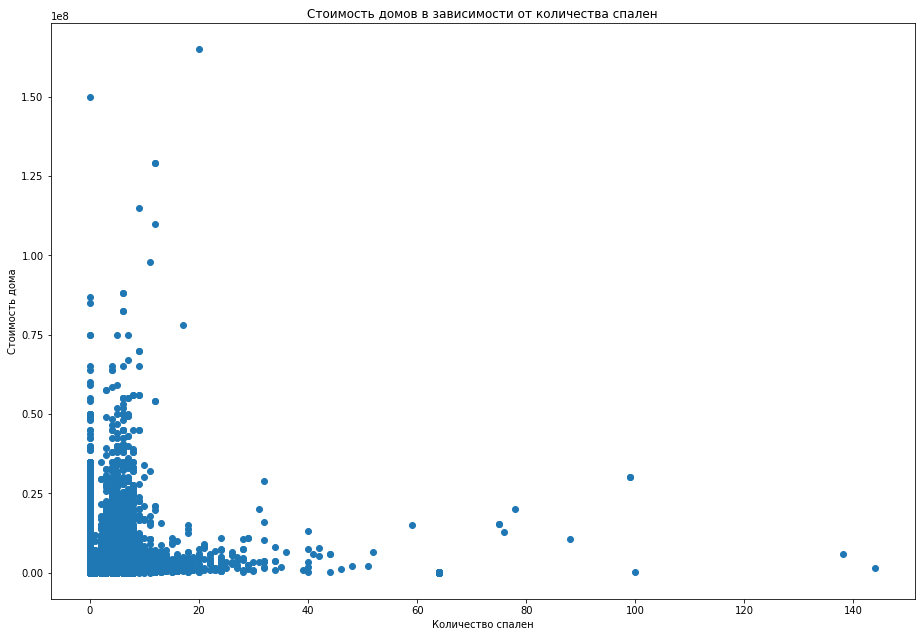

In [59]:
X1 = data[['beds_count', 'target']]

fig_target_beds = plt.figure()
axes_target_beds = fig_target_beds.add_axes([0, 0, 2, 2])
axes_target_beds.set_xlabel('Количество спален')
axes_target_beds.set_ylabel('Стоимость дома')
axes_target_beds.set_title('Стоимость домов в зависимости от количества спален')
plt.plot(X1['beds_count'], X1['target'],'o')
plt.show()

In [60]:
data[data['beds_count']>90]

,status,private pool,homeFacts,fireplace,schools,sqft,zipcode,state,stories,mls-id,PrivatePool,MlsId,target,NAME,ST,...,POPULATION,MALES,FEMALES,HSE_UNITS,VACANT,OWNER_OCC,state_mean,rent_sale,prop_type,city_hash,street_hash,address_hash,baths_count,beds_count,beds_square
113718,active,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': ['7', '8', '4', '8', '9', '6', 'NR...",62376,78045,TX,NaN,NaN,NaN,20193851,1590000,laredo,TX,...,264978.0,114287.0,121804.0,68610.0,5065.0,40489.0,4.608991e+05,0,44,17028,57453,267237,2.0,144,0.0
143453,active,NaN,"{'atAGlanceFacts': [{'factValue': '2002', 'fac...",NaN,"[{'rating': ['9', '9', '4', '10', '8', '5', 'N...",55056,78045,TX,NaN,NaN,NaN,20191670,6000000,laredo,TX,...,264978.0,114287.0,121804.0,68610.0,5065.0,40489.0,4.608991e+05,0,44,17028,391312,192756,4.0,138,0.0
199253,for sale,NaN,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...","30,500 sqft",2215,MA,NaN,NaN,NaN,72567479,30000000,boston,MA,...,661977.0,295951.0,321643.0,272481.0,19782.0,85791.0,1.402198e+06,0,44,10609,267134,466960,55.0,99,0.0
248198,for sale,NaN,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",NaN,"[{'rating': ['2/10'], 'data': {'Distance': ['0...","2,751 sqft",19140,PA,3.0,NaN,NaN,PAPH849396,100000,philadelphia,PA,...,1587761.0,719813.0,806193.0,670171.0,70435.0,324536.0,3.619094e+05,0,44,6370,126930,365637,100.0,100,0.0
325558,for sale,NaN,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,"[{'rating': ['2/10', '3/10'], 'data': {'Distan...","30,500",02215,MA,NaN,NaN,NaN,"81, Boston, MA 02215",30000000,boston,MA,...,661977.0,295951.0,321643.0,272481.0,19782.0,85791.0,1.402198e+06,0,44,10609,267134,466960,55.0,99,0.0


## 7. поле schools

Поле содержит информацию о близлежащих школах. Количество школ – для каждого дома разное. Для каждой школы указывается ее имя, рейтинг, дистанция, какие классы.

Preschool заменяем на PK (судя по той информации, что я нашла, это одно и то же)

Выделяем в отдельные столбцы:
*	количество школ по классам, включая K и PK
*	общее количество школ
*	минимальную, максимальную и среднюю дистанцию до школ
*	максимальный рейтинг школы
*	некая придуманная метрика, которая получается путем перемножения списка рейтингов на список дистанций до школ


In [61]:
#пример данных
data['schools'][0]

"[{'rating': ['8', '6', '4'], 'data': {'Distance': ['1.5 mi', '2.3 mi', '3.4 mi'], 'Grades': ['Preschool to 5', '6 to 8', '9 to 12']}, 'name': ['Silver Ridge Elementary School', 'Driftwood Middle School', 'Hollywood Hills High School']}]"

In [62]:
def make_schools(row):

    #разбираем, какие классы есть в близлежащих школах
    grades = eval(row[1:-1])['data']['Grades']
    
    result={'K':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,'11':0,'12':0, 'PK':0}
    for i in grades:
        i = (str(i).replace(' to ', '-').replace('–', '-')).split(',')
        for ii in i:
            ii = ii.strip().upper().replace('PK','PRESCHOOL')
            if 'PRESCHOOL' in ii:
                result['PK']+=1
                ii = ii.replace('PRESCHOOL','1')
            if 'K' in ii:
                result['K']+=1
                ii = ii.replace('K','1')
            if '-' in ii:
                j = ii.split('-')
                for k in range(int(j[0]), int(j[1])+1):
                    result[str(k)]+=1
    
    #считаем количество школ 
    result['schools_count']=len(eval(row[1:-1])['rating'])
    
    #считаем дистанцию по школам
    result['min_dist']=0
    result['max_dist']=0
    result['mean_dist']=0

    data_list = eval(row[1:-1])['data']['Distance']
    dist_list=[]
    for i in data_list:
        i = i.replace('mi', '').strip()
        try:
            i = float(i)
            dist_list.append(i)
        except:
            print(i)
            i = 0 
    if len(dist_list)>0:
        result['min_dist']=min(dist_list)
        result['max_dist']=max(dist_list)
        result['mean_dist']=mean(dist_list)
    
    #разбираем рейтинги школ
    regex = re.compile('\D+')
    data2_list = eval(row[1:-1])['rating']
    rate_list=[]
    if len(data2_list)>0:
        for i in data2_list:
            i = i.replace('/10','')
            i = regex.sub('', str(i))
            if i != '':
                rate_list.append(int(i))
            else:
                rate_list.append(0)
    if len(rate_list)>0:
        result['max_rate'] = max(rate_list) 
    else:
        result['max_rate']=0
        
    if len(dist_list)==len(rate_list):
        result['average_rate_school']=np.array(dist_list)@np.array(rate_list)
    else:
        result['average_rate_school']=0
    
    return pd.Series(result)

In [63]:
#добавляем кучу новых столбцов с характеристиками по школам
new_columns = ['K','1','2','3','4','5','6','7','8','9','10','11','12', 'PK', 'schools_count', 
              'min_dist', 'max_dist', 'mean_dist', 'max_rate', 'average_rate_school']
data[new_columns] = pd.DataFrame(data['schools'].apply(lambda x: make_schools(x)), index=data.index)

In [64]:
#удаляем исходный столбец про школы
data = data.drop(['schools'], axis = 'columns')

## 8. поле sqft

Поле содержит информацию о площади дома. Отсутствующие значения заменяем на 0. В существующих оставляем только цифры. Если в описании только буквы, то заменяем на 0. Приводим к формату int.

Удаляем выбросы: строки, где площадь дома более 40 млн кв. футов (так как у них указан тип как многоквартирный дом, а стоимость невелика). Для остальных «больших» площадей указан тип «land», понимаем это так, что продается дом с землей.


In [65]:
data['sqft'].fillna(0, inplace=True)

In [66]:
#убираем все символы, кроме цифр. Приводим к формату int
regex_sq = re.compile('\D+')
data['sqft'] = data['sqft'].apply(lambda x: regex_sq.sub('', str(x)))
data['sqft'] = data['sqft'].apply(lambda x: int(x) if x != '' else 0)

In [67]:
#удаляем выбросы. Площадь больше 4000000
data = data.loc[data['sqft']<40000000]
print('осталось {0} значений'.format(len(data)))

осталось 374434 значений


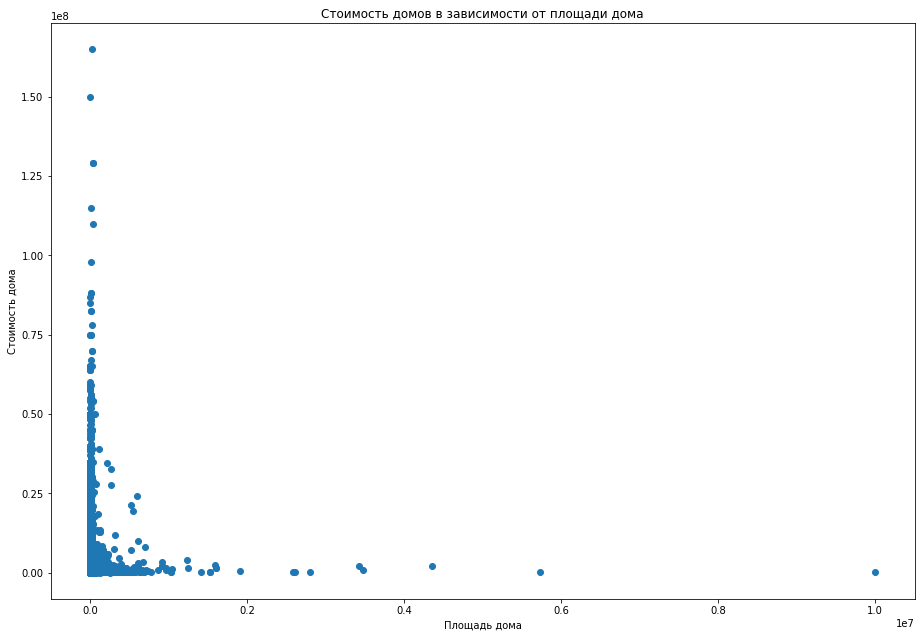

In [68]:
#стоимость домов в зависимости от площади
X_sqft = data[['sqft', 'target']]

fig_target_sqft = plt.figure()
axes_target_sqft = fig_target_sqft.add_axes([0, 0, 2, 2])
axes_target_sqft.set_xlabel('Площадь дома')
axes_target_sqft.set_ylabel('Стоимость дома')
axes_target_sqft.set_title('Стоимость домов в зависимости от площади дома')
plt.plot(X_sqft['sqft'], X_sqft['target'],'o')
plt.show()

## 9. поле zipcode

Поле содержит информацию о почтовом индексе. Оставляем в поле только цифры (избавляемся от остальных знаков). Преобразуем в тип int. Целочисленные значения записываем в новое поле zipcode_int.

In [69]:
#убираем все символы, кроме цифр. Приводим к формату int
regex = re.compile('\D+')
data['zipcode_int'] = data['zipcode'].apply(lambda x: int(regex.sub('', str(x))) if regex.sub('', str(x))!='' else 0)

## 10. private pool  и PrivatePool

Поля содержат информацию о наличии приватного бассейна. Судя по всему, различные названия полей пришли из разных систем, но данные содержат примерно одинаковые.

Формируем новый столбец, который содержит 1, если бассейн указан хотя бы в одном из этих полей, и 0 в противном случае. 


In [70]:
data['private pool1'] = data['private pool'].apply(lambda x: 1 if str(x).lower()=='yes' else 0)
data['PrivatePool1'] = data['PrivatePool'].apply(lambda x: 1 if str(x).lower()=='yes' else 0)
data['pool'] = data[['PrivatePool1','private pool1']].values.max(1)

In [71]:
data['private pool'].unique()

array([nan, 'Yes'], dtype=object)

In [72]:
data['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [73]:
data[data['pool'] > 0][['PrivatePool','private pool', 'pool']]

,PrivatePool,private pool,pool
1,yes,NaN,1
4,yes,NaN,1
13,yes,NaN,1
16,Yes,NaN,1
19,yes,NaN,1
...,...,...,...
374657,yes,NaN,1
374666,yes,NaN,1
374667,yes,NaN,1
374671,yes,NaN,1


In [74]:
#удаляем ненужные столбцы
data = data.drop(['PrivatePool','private pool','PrivatePool1','private pool1'], axis='columns')

## 11. поле fireplace

Поле содержит информацию об отоплении (хотя название поля говорит вроде бы о наличии камина). Данные очень грязные. В некоторых строках написано «да», в некоторых строках идет перечисление вообще всех отопительных приборов в доме.

Преобразуем этот столбец в fireplace_y_n, который будет содержать информацию о том, есть (1) или нет (0) информация об отоплении. В качестве «нет информации» считаем значения 'nan', 'not applicable', 'no'.

Делаем еще одно поле с количеством характеристик обогрева (сколько вариантов перечислено в исходном поле).


In [75]:
print(len(data['fireplace'].unique()))
data['fireplace'].unique()[:30]

1675


array([nan, 'yes', 'Yes',
       '3+ Fireplace, Exterior Fireplace, Fireplace Family Rm',
       'Gas Logs, Gas Starter', '1', 'Ceiling Fan, Water Filter',
       'Wood Burning', '2', 'Not Applicable', 'Fireplace', 'Family Room',
       '3', '2+ Fireplaces', 'Gas Logs, In Great Room', 'Gas/Gas Logs',
       'Direct Vent, One', 'FAMILYRM',
       'Fireplace - Gas, Flooring - HardWood, Walk-In Closet(s), Master Bedroom - Sitting Area',
       '0',
       'Air Filter, Ceiling Fan, Utility Connection, Walk-In Closets',
       'Air Filter, Ceiling Fan, Utility Connection',
       'Ceiling Fan, Utility Connection',
       '2 or more Fireplaces, Brick Fireplace, Fireplace-Bedroom, Fireplace-Living Rm, Tile Fireplace',
       'Wood', 'N/K', 'Fireplace YN', 'Walk-In Closets',
       'Fireplace Insert',
       'Ceiling Fan, Redecorated, Utility Connection, Walk-In Closets'],
      dtype=object)

In [76]:
#пока простая обработка "есть/нет"
data['fireplace_y_n'] = data['fireplace'].apply(lambda x: 0 if (str(x) == 'nan' 
                                                                or str(x).lower() == 'not applicable' 
                                                                or str(x).lower() == 'no') else 1)



In [77]:
#Работа с обогревом. Смотрим частоту встречания разных вариантов
fireplace_list = []
for x in data['fireplace']:
    if type(x) is str:
        #print(ast.literal_eval(x))
        li = x.split(',') #преобразуем строку "со списком" в настоящий список
        #print(li)
        for i in li:
            fireplace_list.append(i.strip())

#считаем сколько раз упоминается 
fireplace_dict = {} #делаем словарь с количеством упоминаний
for i in fireplace_list:
    if i not in fireplace_dict.keys():
        fireplace_dict[i] = 0
    fireplace_dict[i] += 1

In [78]:
fireplace_dict

{'yes': 50106,
 'Yes': 20761,
 '3+ Fireplace': 9,
 'Exterior Fireplace': 50,
 'Fireplace Family Rm': 185,
 'Gas Logs': 1252,
 'Gas Starter': 130,
 '1': 14283,
 'Ceiling Fan': 1264,
 'Water Filter': 25,
 'Wood Burning': 1143,
 '2': 2367,
 'Not Applicable': 1924,
 'Fireplace': 861,
 'Family Room': 543,
 '3': 554,
 '2+ Fireplaces': 9,
 'In Great Room': 217,
 'Gas/Gas Logs': 341,
 'Direct Vent': 31,
 'One': 421,
 'FAMILYRM': 632,
 'Fireplace - Gas': 56,
 'Flooring - HardWood': 74,
 'Walk-In Closet(s)': 7,
 'Master Bedroom - Sitting Area': 6,
 '0': 271,
 'Air Filter': 153,
 'Utility Connection': 657,
 'Walk-In Closets': 1018,
 '2 or more Fireplaces': 8,
 'Brick Fireplace': 13,
 'Fireplace-Bedroom': 5,
 'Fireplace-Living Rm': 20,
 'Tile Fireplace': 4,
 'Wood': 230,
 'N/K': 51,
 'Fireplace YN': 295,
 'Fireplace Insert': 32,
 'Redecorated': 133,
 '# Fireplaces - Gas': 54,
 'Extra Closets': 641,
 'Storage': 623,
 '1 Fireplace': 740,
 'In Den/Family Room': 209,
 'In Kitchen/Dining Room': 21,
 'O

In [79]:
#посчитаем, сколько характеристик указано для дома
data['fp_count']=data['fireplace'].apply(lambda x: len(str(x).split(',')))

In [80]:
data[data['fp_count']>3][['fireplace_y_n','fireplace', 'fp_count']]

,fireplace_y_n,fireplace,fp_count
497,1,"Fireplace - Gas, Flooring - HardWood, Walk-In ...",4
596,1,"Air Filter, Ceiling Fan, Utility Connection, W...",4
685,1,"2 or more Fireplaces, Brick Fireplace, Firepla...",5
1045,1,"Ceiling Fan, Redecorated, Utility Connection, ...",4
1101,1,"Ceiling Fan, Extra Closets, Storage, Utility C...",4
...,...,...,...
373702,1,"Basement Fireplace, Free Standing Wood Stove, ...",4
373971,1,"Ceiling Fan, Elevator, Extra Closets, Storage,...",5
373975,1,"Ceiling Fan, Humidifier, Intercom, Storage, Ut...",6
374291,1,"Ceiling Fan, Hot Tub, Utility Connection, Walk...",4


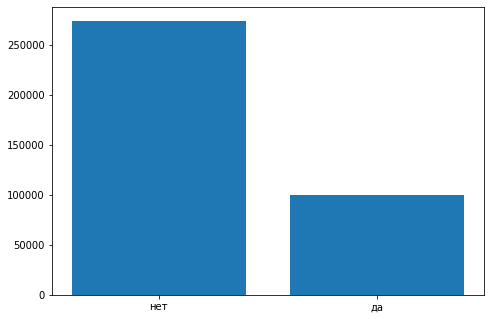

In [81]:
#считаем распределение 
fireplace = data.groupby('fireplace_y_n')['fireplace_y_n'].count().sort_values(ascending=False)

fig_fireplace = plt.figure()
axes_fireplace = fig_fireplace.add_axes([0,0,1,1])
axes_fireplace.bar(x = ['нет', 'да'], height = fireplace.values)
axes_fireplace.set_xticklabels(['нет', 'да'], rotation = 0 )    #  Поворот текста
plt.show()

In [82]:
data=data.drop(['fireplace'], axis = 'columns')

## 12. поле stories

Поле содержит информацию о количестве этажей в продаваемом доме. Либо же, на каком этаже находится квартира.

Так как данные очень грязные, то просто пытаемся привести данные в тип float. Если это не получается, то убираем все буквы и приводим к типу float.

Тип float выбран из-за того, что в значениях может быть, например, «1.5 level»


In [83]:
data['stories'].unique()

array([nan, '1.0', '3.0', '0', '1', '2', 'One', '0.0', '2.0', '5', '3',
       '1.00', '1 Story/F.R.O.G.', '5.0', '17', 'Townhouse', '2 Story',
       '3+', '10.0', '2.0000', '1 Story', 'High-Rise', '4', '7.0', '9.0',
       '4.0', 'Two', 'Three Or More', '2.00', 'Site Built', '9', '1.000',
       'Mid-Rise', '12.0', 'Multi/Split', '3.00', '6.0', '1.50',
       'Acreage', 'Ranch', 'Two Story or More', 'Manufactured Doublewide',
       'Tri-Level', '3 Story', '2.5', 'One Story', '32',
       '2 Level, Site Built', '40.0', '12', '1.5', '60', 'Ranch/1 Story',
       'Garden', '11.0', 'Lot', 'Split Foyer', 'Condominium', '2.50', '8',
       '8.0', '20.0', '1 Level, Site Built', '1.5 Level, Site Built',
       '2 Story/Basement', 'One Level', '3 Story, Split Level',
       'Traditional', 'Stories/Levels', '1.5000', '1.0000', '15', '4.00',
       '1 Story/Ranch', '2 Stories', '24.0', '3.0000', ', 2',
       'One and One Half', '1 Story Basement', '1 Level', 'Farm', '14',
       '18.0', '16.0

In [84]:
# заменяем нан на 1 этаж
data['stories'].fillna(1, inplace=True)

def make_stories(row):
    regex_sq = re.compile('\D+')
    try:
        row=float(row)
    except:
        row=regex_sq.sub('', str(row))
        if row != '':
            row = float(row)
        else:
            row = 1
    return row

#убираем все символы, кроме цифр. Приводим к формату int
regex_sq = re.compile('\D+')
data['stories_count']=data['stories'].apply(lambda x: make_stories(x))

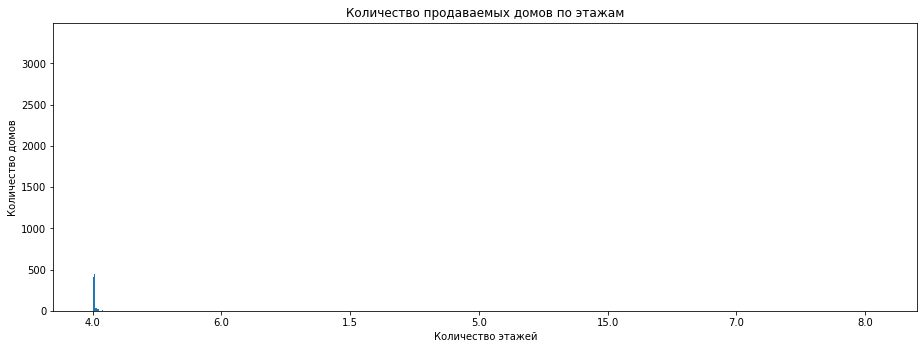

In [85]:
#посмотрим на распределение количества домов по этажам
stories = data.groupby('stories_count')['stories_count'].count().sort_values(ascending=False)

fig_stories  = plt.figure()
axes_stories  = fig_stories.add_axes([0,0,2,1])
axes_stories.bar(x = stories.index[4:], height = stories.values[4:])
axes_stories.set_xlabel('Количество этажей')
axes_stories.set_ylabel('Количество домов')
axes_stories.set_title('Количество продаваемых домов по этажам')

axes_stories.set_xticklabels(stories.index[4:], rotation =0 )    #  Поворот текста
plt.show()

In [86]:
#удалим выбросы, когда этажей больше 1000
data = data.loc[data['stories_count']<1000]

In [87]:
data=data.drop(['stories'], axis = 'columns')

## 13. поле state

Поле содержит двухбуквенное обозначение штата, в котором находится дом. Кодируем его по порядку с помощью метода factorize. 

Сохраняем на будущее список категорий с порядковыми номерами. Это пригодится в дальнейшем, когда надо будет преобразовывать строку с входными данными.

In [88]:
data['state'].unique()

array(['FL', 'CA', 'TX', 'TN', 'IA', 'IL', 'PA', 'AZ', 'NY', 'OH', 'IN',
       'MI', 'NV', 'OR', 'NC', 'CO', 'GA', 'DC', 'WA', 'MA', 'VT', 'WI',
       'MD', 'KY', 'MO', 'OK', 'UT', 'MT', 'VA', 'ME', 'NJ', 'SC', 'MS',
       'DE', 'OS', 'Fl', 'SD', 'OT', 'AL', 'Co'], dtype=object)

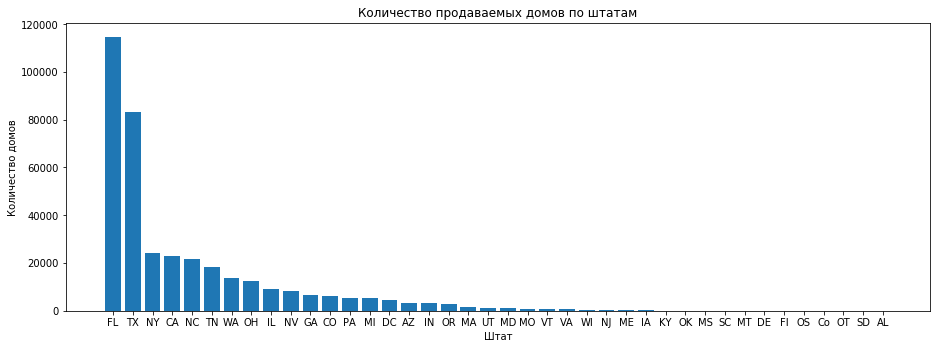

In [89]:
#считаем распределение по штатам
states = data.groupby('state')['state'].count().sort_values(ascending=False)

fig_states = plt.figure()
axes_states = fig_states.add_axes([0,0,2,1])
axes_states.bar(x = states.index, height = states.values)
axes_states.set_xlabel('Штат')
axes_states.set_ylabel('Количество домов')
axes_states.set_title('Количество продаваемых домов по штатам')

axes_states.set_xticklabels(states.index, rotation =0 )    #  Поворот текста
plt.show()

In [90]:
#заменим на числа
#в конце сохраним этот список, чтобы обрабатывать строку на входе
data['state_encoding'], states_list = data['state'].factorize()

In [91]:
#убираем обработанный столбец
data = data.drop(['state'], axis = 'columns')

## 14. поле HomeFacts

Поле содержит комплексную информацию по дому, разложенную в словарь со следующими метками: {'Cooling', 'Heating', 'Parking', 'Price/sqft', 'Remodeled year', 'Year built', 'lotsize'}

Разбираем эту информацию по соответствующим полям. Затем 'Cooling', 'Heating', 'Parking' заменяем на 1, если там есть какая-то информация, на 0, если ее нет.

'Price/sqft' – избавляемся от лишних символов, переводим в тип int

'Remodeled year', 'Year built' – выделяем год. Удаляем выброс со странным очень большим годом в Годе постройки.

'lotsize' – выделяем числа. Переводим все в единый формат (акры в квадратные футы)


In [92]:
data['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2009', 'factLabel': 'Year built'}, {'factValue': '2010', 'factLabel': 'Remodeled year'}, {'factValue': 'Central Air', 'factLabel': 'Heating'}, {'factValue': 'Has Cooling', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '1,530 Sq. Ft.', 'factLabel': 'lotsize'}, {'factValue': '$200 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}"

In [93]:
#смотрим, какие вообще факты могут быть. Если их небольшое количество, то разложим в разные столбцы
for i in data['homeFacts']:
    fact_list = []
    hf = eval(i)['atAGlanceFacts']
    for k in hf:
        fact_list.append(k['factLabel'])
set(fact_list)

{'Cooling',
 'Heating',
 'Parking',
 'Price/sqft',
 'Remodeled year',
 'Year built',
 'lotsize'}

In [94]:
def make_facts(row, columns):
    fact_dict = {}
    for i in columns:
        fact_dict[i]=float('nan')
    row = eval(row)['atAGlanceFacts']
    for i in row:
        fact_dict[i['factLabel']]=i['factValue']
    return pd.Series(fact_dict)
    

In [95]:
fact_columns = ['Cooling',  'Heating', 'Parking', 'Price/sqft', 'Remodeled year', 'Year built', 'lotsize']
data[fact_columns]=data['homeFacts'].apply(lambda x: make_facts(x,fact_columns))

In [96]:
data[fact_columns]

,Cooling,Heating,Parking,Price/sqft,Remodeled year,Year built,lotsize
0,Has Cooling,Central Air,,$200 / Sq. Ft.,2010,2009,"1,530 Sq. Ft."
1,Central,Forced Air,"Carport, Attached Garage",$187/sqft,1991,1991,0.46 acres
2,,,,None,,,1.37 acres
3,,,,None,2006,2006,"8,245 Sq. Ft."
4,Central,Other,Attached Garage,$270/sqft,2003,2003,"2,500 sqft"
...,...,...,...,...,...,...,...
374682,Central,Forced air,No Data,$86,1993,1993,None
374683,None,Forced Air,Detached Garage,$306/sqft,,1885,"3,125 sqft"
374684,,,,None,,,
374685,Central,Other,2 spaces,$198,2002,2002,"1,071 sqft"


In [97]:
#Cooling, Heating, Parking меняем на 1 (есть), 0(нет)
for i in ['Cooling', 'Heating', 'Parking']:
    data[i].fillna(0, inplace = True)
    data[i] = data[i].apply(lambda x: 0 if x == np.nan or x in ['', 'No','None', 'no', 0, 'No Data'] else 1)

In [98]:
#в цене за кв. фут избавляемся от всяких лишних знаков, переводим в целое число
def make_price(row):
    row = str(row).replace('$','').replace('/sqft','').replace(' / Sq. Ft.', '').replace(',','')
    try:
        row = int(row)
    except:
        if row in ['None', 'No Info', 'No Data', '', 'Contact manager']:
            row = 0
        else:
            row = 0
    return row

In [99]:
data['price']=data['Price/sqft'].apply(lambda x: make_price(x))

In [100]:
#преобразуем год в число
for i in ['Remodeled year', 'Year built']:
    data[i.split()[0]] = data[i].apply(lambda x: int(x) if str(x) not in ['', 'None','No Data'] else 0)


In [101]:
#удалим строки с выбросом по году постройки
data = data.loc[data['Year']!=559990649990]

In [102]:
#в размере лота убираем лишние знаки, переводим все в единые единицы измерения
def make_lot(row):
    row1 = row
    row = str(row).replace('$','').replace(' sqft lot','').replace(' Sq. Ft.', '').replace(' sqft', '').replace(',','')
    try:
        row = float(row)
    except:
        if row.lower().find('acre') >-1:
            row = row.lower().replace(' lot', '').replace(' acres', '').replace(' acre', '').replace(' acres', '')
        try:
            row = float(row) * 43560.04
        except:
            if row in ['None', 'No Info', 'No Data', '', 'Contact manager', '--', '—']:
                row = 0
            else:
                print(row, '->', row1)
    return row

In [103]:
data['lot'] = data['lotsize'].apply(lambda x: make_lot(x))

In [104]:
#удаляем обработанные столбцы
data = data.drop(['lotsize', 'Remodeled year', 'Year built', 'Price/sqft', 'homeFacts'], axis = 'columns')

## 15. mls-id

Выявлено, что поля mls-id и MlsId идентичны, содержат некий идентификатор дома. Дома, имеющие один и тот же идентификатор, но в различных полях, имеют практически идентичное описание в других полях. Однако, стоимость иногда отличается.

Объединяем оба идентификатора в один столбец.

Удаляем все уже обработанные столбцы и удаляем дубликаты строк (их оказалось порядка 80). 

Кроме того, есть строки, в которых одинаковые значения в полях, но разные значения целевой переменной. Такие строки удаляем совсем, так как нам неизвестно, какие значения более правильные.


In [105]:
#делаем списки идентификаторов и ищем пересечение
s1 = set(data['mls-id'].unique())
s2 = set(data['MlsId'].unique())
s3 = s2.intersection(s1)
print('Пересекаются {0} значений'.format(len(s3)))
print('mls-id = {0} значений, MlsId = {1} значений'.format(len(s1), len(s2)))

Пересекаются 8908 значений
mls-id = 25027 значений, MlsId = 233031 значений


In [106]:
#соединяем идентификаторы в одну колонку, так удобнее с ними работать
data['mls-id'].fillna('', inplace=True)
data['MlsId'].fillna('', inplace=True)
data['new_id']=data['mls-id'].astype(str)+data['MlsId'].astype(str)

#проверяем, может есть строки, в которых идентификатор совсем не проставлен. Эти строки не трогаем, оставляем как есть
print('В {0} строках не проставлен идентификатор'.format(data[data['new_id']=='']['new_id'].count()))

data=data.drop(['mls-id', 'MlsId'], axis = 'columns')

В 39295 строках не проставлен идентификатор


In [107]:
#избавляемся от оставшихся лишних столбцов
data=data.drop(['status', 'zipcode'], axis = 'columns')

In [108]:
#остались только обработанные столбцы. Попробуем поискать полные дубликаты
data1 = data.drop_duplicates()
print(len(data), '->', len(data1))

374430 -> 374359


In [109]:
#полные дубликаты удалены. Посчитаем hash для идентификатора. Так как он содержит и буквы тоже
data= data1
hash_space = 500000
data['new_id'] = data['new_id'].apply(lambda x: hash(''.join(x.lower().split())) % hash_space)

# дополнительные признаки

In [116]:
data['sqft_lot'] = data['sqft']+data['lot']
data['CAPITAL'].fillna(0, inplace = True)
data['POPULATION'].fillna(0, inplace = True)
data['MALES'].fillna(0, inplace = True)
data['FEMALES'].fillna(0, inplace = True)
data['HSE_UNITS'].fillna(0, inplace = True)
data['VACANT'].fillna(0, inplace = True)
data['OWNER_OCC'].fillna(0, inplace = True)

In [117]:
data['mal_femal'] = data['MALES']/data['FEMALES']
data['vacant_units'] = data['VACANT']/data['HSE_UNITS']
data['mal_vacant'] = data['MALES']/data['VACANT']
data['mal_pop']=data['MALES']/data['POPULATION']

## Удаляем все оставшиеся ненужные столбцы и сохраняем датасет для дальнейшей работы

In [110]:
#удаляем дубликаты строк, которые имеют разную стоимость
#удаляем все спорные строки, так как неизвестно, какая из них правильная
columns = list(set(data.columns) - set(['target']))
data.drop_duplicates(subset = columns, keep = False, inplace= True) 

In [119]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374333 entries, 0 to 374686
Data columns (total 57 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sqft                 374333 non-null  int64  
 1   target               374333 non-null  int64  
 2   CAPITAL              374333 non-null  float64
 3   POPULATION           374333 non-null  float64
 4   MALES                374333 non-null  float64
 5   FEMALES              374333 non-null  float64
 6   HSE_UNITS            374333 non-null  float64
 7   VACANT               374333 non-null  float64
 8   OWNER_OCC            374333 non-null  float64
 9   state_mean           374333 non-null  float64
 10  rent_sale            374333 non-null  int64  
 11  prop_type            374333 non-null  int64  
 12  city_hash            374333 non-null  int64  
 13  street_hash          374333 non-null  int64  
 14  address_hash         374333 non-null  int64  
 15  baths_count      

In [118]:
data1 = data.drop(['NAME', 'ST'], axis = 'columns')

In [120]:
#сохраняем обработанный датасет
data1.to_csv('data4ml_6_cities.csv', encoding='utf-8', index=False)


In [114]:
#сохраняем список штатов, он нам потом понадобится
with open('states_list.txt', 'wb') as f:
    pickle.dump(states_list, f)

In [115]:
#сохраняем среднюю стоимость по штатам, она нам потом понадобится
with open('mean_target.txt', 'wb') as f:
    pickle.dump(mean_target, f)

## На этом первый этап закончен